## Visualizing ilastik tracking results in napari

This notebook demonstrates how to visualize tracks that have been created from the napari tracking workflow in napari
using the Tracks layer, which was introduced [in PR 1361](https://github.com/napari/napari/pull/1361).



In [1]:
import napari
import pandas as pd
import numpy as np
from napari.utils import nbscreenshot

In [2]:
# File paths
csvfile = "demo/ilastik_tracking_results.csv"
label_h5 = "demo/ilastik_Object-Identities.h5"
raw_h5 = "demo/raw_data.h5"

Let's read the `.csv` file using the pandas package.

In [3]:
df = pd.read_csv(csvfile)

Inspect the available columns and have a look at the first row to see what the data looks like

In [4]:
df.columns

Index(['frame', 'labelimageId', 'trackId', 'lineageId', 'parentTrackId',
       'mergerLabelId', 'Convexity_0', 'Number_of_Defects_0',
       'Mean_Defect_Displacement_0', 'Mean_Defect_Area_0',
       'Variance_of_Defect_Area_0', 'Convex_Hull_Center_0',
       'Convex_Hull_Center_1', 'Convex_Hull_Center_2', 'Object_Center_0',
       'Object_Center_1', 'Object_Center_2', 'Object_Area_0',
       'Kurtosis_of_Intensity_0', 'Kurtosis_of_Intensity_1',
       'Maximum_intensity_0', 'Maximum_intensity_1', 'Mean_Intensity_0',
       'Mean_Intensity_1', 'Minimum_intensity_0', 'Minimum_intensity_1',
       'Principal_components_of_the_object_0',
       'Principal_components_of_the_object_1',
       'Principal_components_of_the_object_2',
       'Principal_components_of_the_object_3',
       'Principal_components_of_the_object_4',
       'Principal_components_of_the_object_5',
       'Principal_components_of_the_object_6',
       'Principal_components_of_the_object_7',
       'Principal_component

In [5]:
df.head()

,frame,labelimageId,trackId,lineageId,parentTrackId,mergerLabelId,Convexity_0,Number_of_Defects_0,Mean_Defect_Displacement_0,Mean_Defect_Area_0,...,Bounding_Box_Maximum_0,Bounding_Box_Maximum_1,Bounding_Box_Maximum_2,Bounding_Box_Minimum_0,Bounding_Box_Minimum_1,Bounding_Box_Minimum_2,Size_in_pixels_0,Center_of_the_object_0,Center_of_the_object_1,Center_of_the_object_2
0,0,1,2,2,0,0,0.298701,1,0.669782,1620.0,...,181,332,19,167,317,8,690.0,173,324,12
1,0,2,3,3,0,0,0.389568,1,2.656275,1299.0,...,145,367,16,126,353,8,829.0,136,359,11
2,0,3,4,4,0,0,0.492857,1,0.683170,426.0,...,193,282,16,183,270,9,414.0,187,275,11
3,0,4,5,5,0,0,0.350649,1,0.953997,900.0,...,192,303,18,181,289,9,486.0,186,295,13
4,0,5,6,6,0,0,0.479798,1,1.494977,618.0,...,110,386,19,99,374,10,570.0,104,379,13


Curiously, we notice that there are columns named `Object_Center_*` as well as columns named `Center_of_the_Object_*`.
As I have worked with volumetric data, there are three of these columns, `...0, ...1, ...3` each.
I have not looked deeply into where the differently named object centre columns originate in ilastik, but I noted
`Object_Center_*` sometimes have `0, 0, 0` coordinates where the `Center_of_the_Object_*` do not. This is reflected in [the following discussion on image.sc](https://forum.image.sc/t/ilastik-tracking-results-as-csv-file-meaning-of-rows-with-0-0-0-location/42638). k-dominic suggested these may referring to objects that may have merged into larger objects.


Let's look what we need to feed into the napari tracks layer:

In [6]:
napari.Viewer.add_tracks?

Signature:
napari.Viewer.add_tracks(
    self,
    data,
    *,
    properties=None,
    graph=None,
    tail_width=2,
    tail_length=30,
    name=None,
    metadata=None,
    scale=None,
    translate=None,
    opacity=1,
    blending='additive',
    visible=True,
    colormap='turbo',
    color_by='track_id',
    colormaps_dict=None,
)
Docstring:
Add a Tracks layer to the layer list. 

Parameters
----------
data : array (N, D+1)
    Coordinates for N points in D+1 dimensions. ID,T,(Z),Y,X. The first
    axis is the integer ID of the track. D is either 3 or 4 for planar
    or volumetric timeseries respectively.
properties : dict {str: array (N,)}, DataFrame
    Properties for each point. Each property should be an array of length N,
    where N is the number of points.
graph : dict {int: list}
    Graph representing associations between tracks. Dictionary defines the
    mapping between a track ID and the parents of the track. This can be
    one (the track has one parent, and the p

The actual track IDs, time points and spatial coordinates need to be passed as follows
```
data : array (N, D+1)
    Coordinates for N points in D+1 dimensions. ID,T,(Z),Y,X. The first
    axis is the integer ID of the track. D is either 3 or 4 for planar
    or volumetric timeseries respectively.
```

I tried to feed these in directly from the data frame, but it turns out they also need to be sorted by trackId and time point.
Also, a `trackId` of `0` seems to indicate objects that couldn't be tracked. We need to remove those. So let's do the required tidying:

In [7]:
df = df[df.trackId>0]
df = df.sort_values(by=['trackId', 'frame'])

Now that the data frame has been sorted and untracked objects have been removed, we can simply select the required columns and turn them into a numpy array:

In [8]:
tracks = np.array(df[["trackId","frame", "Center_of_the_object_2", "Center_of_the_object_1", "Center_of_the_object_0"]])

Now we can start the visualization. In the notebook we need to enable the Qt gui event loop. Wait a few moments after executing the next cell:

In [9]:
%gui qt

Now display the track with default parameters

In [10]:
v = napari.Viewer()
v.add_tracks(tracks, name='ilastik tracks')

<Tracks layer 'ilastik tracks' at 0x7fa235df6810>

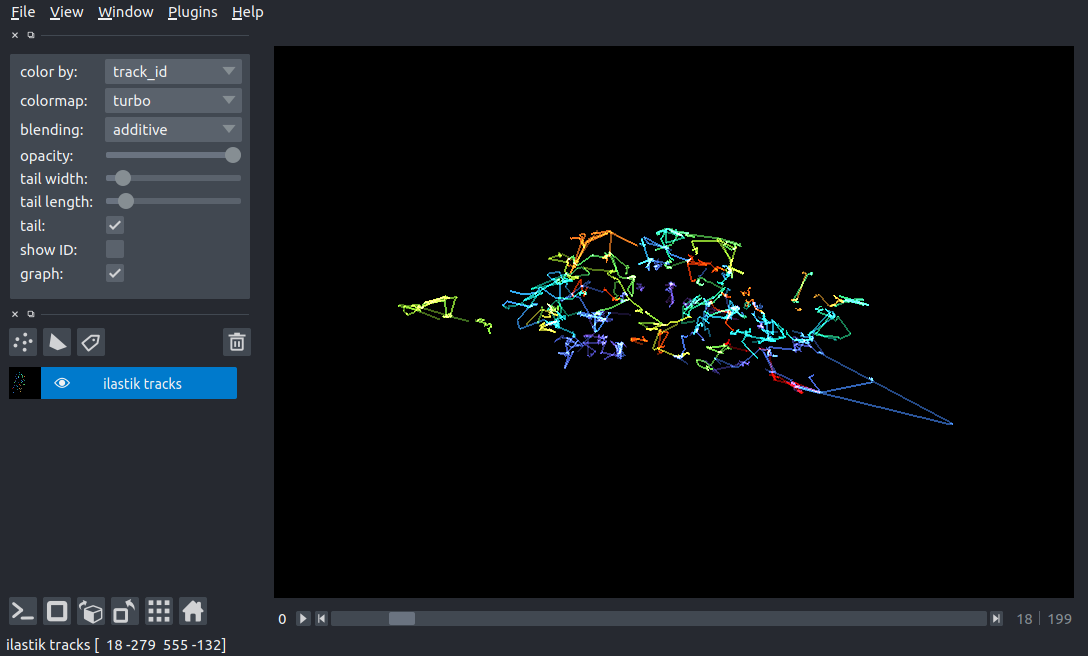

In [11]:
nbscreenshot(v) # after switching to 3D view and some gui adjustments

## Visualizing properties

Above, we just visualized the bare tracks, with the default color lookup table (LUT) for labels.

We can also pass some other numerical properties of the tracked objects as a dictionary and visualize these using different LUTs. 

In the following cells we create a dictionary object for some of the properties and show how to add layers showing different properties.

Note that as an alternative to creating several layers, you can also switch between different properties and LUTs using the drop-down menus in a single layer using the GUI elements.

In [12]:
properties_vis_cols = df[["Size_in_pixels_0", 'Total_Intensity_0', 'Total_Intensity_1', 'Maximum_intensity_0', 'Maximum_intensity_1', 'frame']]
properties_vis_cols.head()

,Size_in_pixels_0,Total_Intensity_0,Total_Intensity_1,Maximum_intensity_0,Maximum_intensity_1,frame
0,690.0,60840.0,48573.0,140.0,145.0,0
95,520.0,34576.0,39339.0,141.0,146.0,1
193,694.0,55706.0,51526.0,141.0,146.0,2
292,537.0,31659.0,41533.0,115.0,146.0,3
398,501.0,28347.0,38355.0,126.0,146.0,4


In [13]:
properties_vis_dict = properties_vis_cols.to_dict(orient = 'list')

In [14]:
properties_vis_dict.keys()

dict_keys(['Size_in_pixels_0', 'Total_Intensity_0', 'Total_Intensity_1', 'Maximum_intensity_0', 'Maximum_intensity_1', 'frame'])

In [18]:
tracklayer_size = v.add_tracks(tracks, properties=properties_vis_dict, name='Size track',color_by= 'Size_in_pixels_0', colormap='viridis')

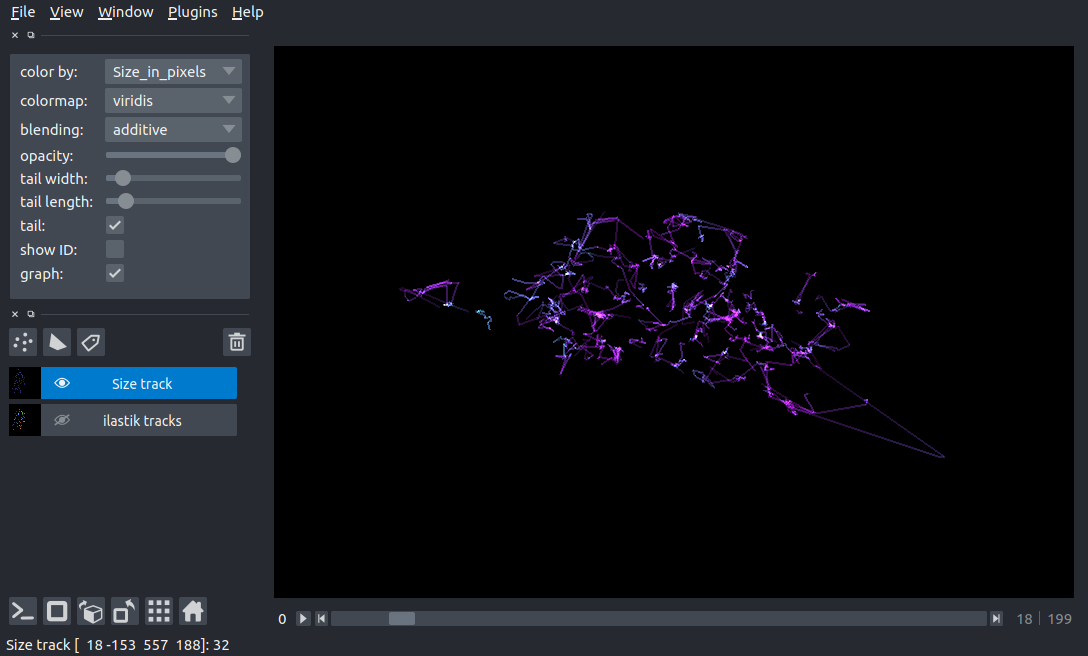

In [19]:
nbscreenshot(v)

In [20]:
# Something is buggy below. Despite specifying color_by, the tracks are coloured by size.
# Reported here: https://github.com/napari/napari/issues/1722
# Might be fixed by the time you read this. Until then, you need to select the property 
# to color by manually from the pull down menu.

v.add_tracks(tracks, properties=properties_vis_dict, name='Max int Ch0', color_by= 'Maximum_intensity_0', colormap='green')
maxlayer = v.add_tracks(tracks, properties=properties_vis_dict, name='Max int Ch1', color_by= 'Maximum_intensity_1', colormap='magenta')

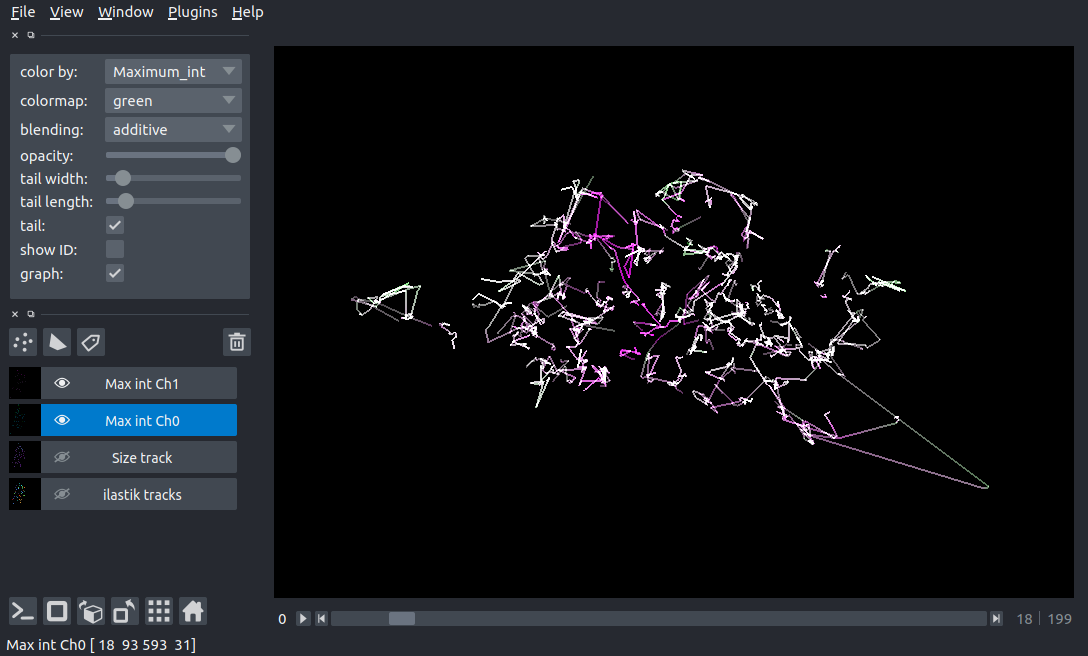

In [21]:
nbscreenshot(v)

## Adding raw data and segmentation labels

To proof-read the tracks, one typically will also want to look at the segmentation and raw pixel data. When working with ilastik, it is typical that both the raw data as well as the exported segmentation are available as `hdf5` files.

Below, we use `h5py` to open the hdf5 file. We wrap the array data in a `dask` array which should give us lazy loading.

Due to the size of the files, they are not shared with this notebook.

In [23]:
import dask.array as da
import h5py

In [29]:
# segmentation
object_label_hdf5 = h5py.File(label_h5, "r")

In [25]:
object_label_hdf5.keys()

<KeysViewHDF5 ['exported_data']>

In [26]:
object_label_hdf5['exported_data'].shape

(200, 80, 608, 400, 1)

There is a singleton dimension which I will remove with `da.squeeze`

In [27]:
object_label_dask = da.from_array(object_label_hdf5['exported_data'])

In [28]:
v.add_labels(da.squeeze(object_label_dask))

<Labels layer 'Labels' at 0x7fa213d5c750>

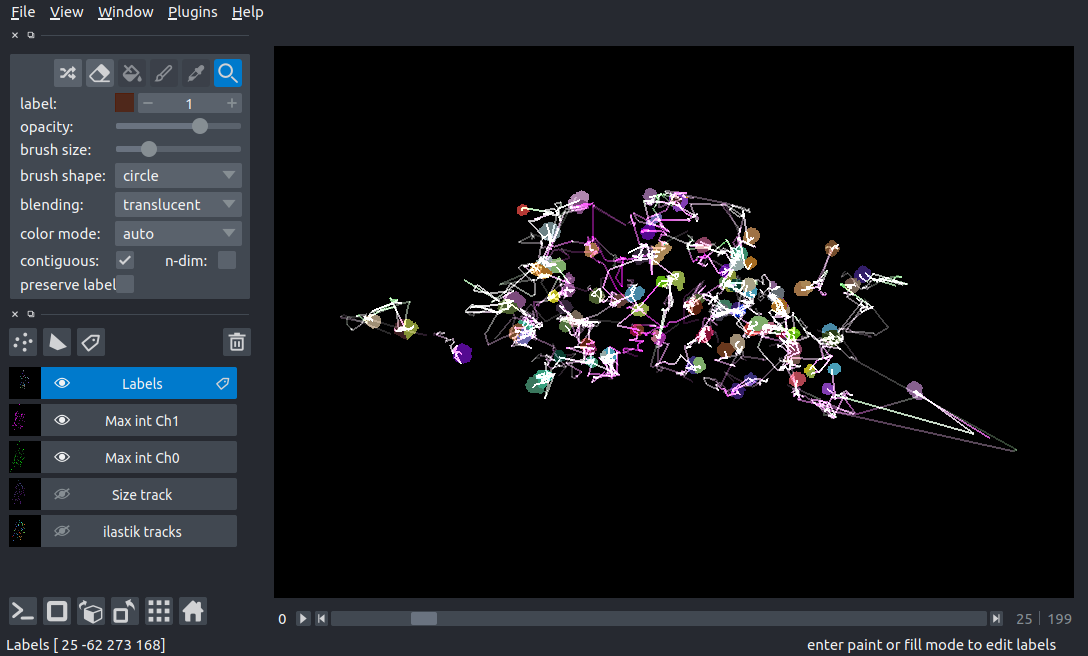

In [31]:
nbscreenshot(v)

In [34]:
raw_data_hdf5 = h5py.File(raw_h5, "r")


In [37]:
raw_data_hdf5.keys()

<KeysViewHDF5 ['__DATA_TYPES__', 'data']>

In [38]:
raw_data_hdf5['data'].shape

(200, 80, 608, 400, 2)

In [39]:
raw_data = da.from_array(raw_data_hdf5['data'])

In [42]:
v.add_image(raw_data[...,0], name='raw data 488nm',colormap='green', blending='additive')
v.add_image(raw_data[...,1], name='raw data 560nm',colormap='magenta', blending='additive')

<Image layer 'raw data 560nm [1]' at 0x7fa17cf22fd0>

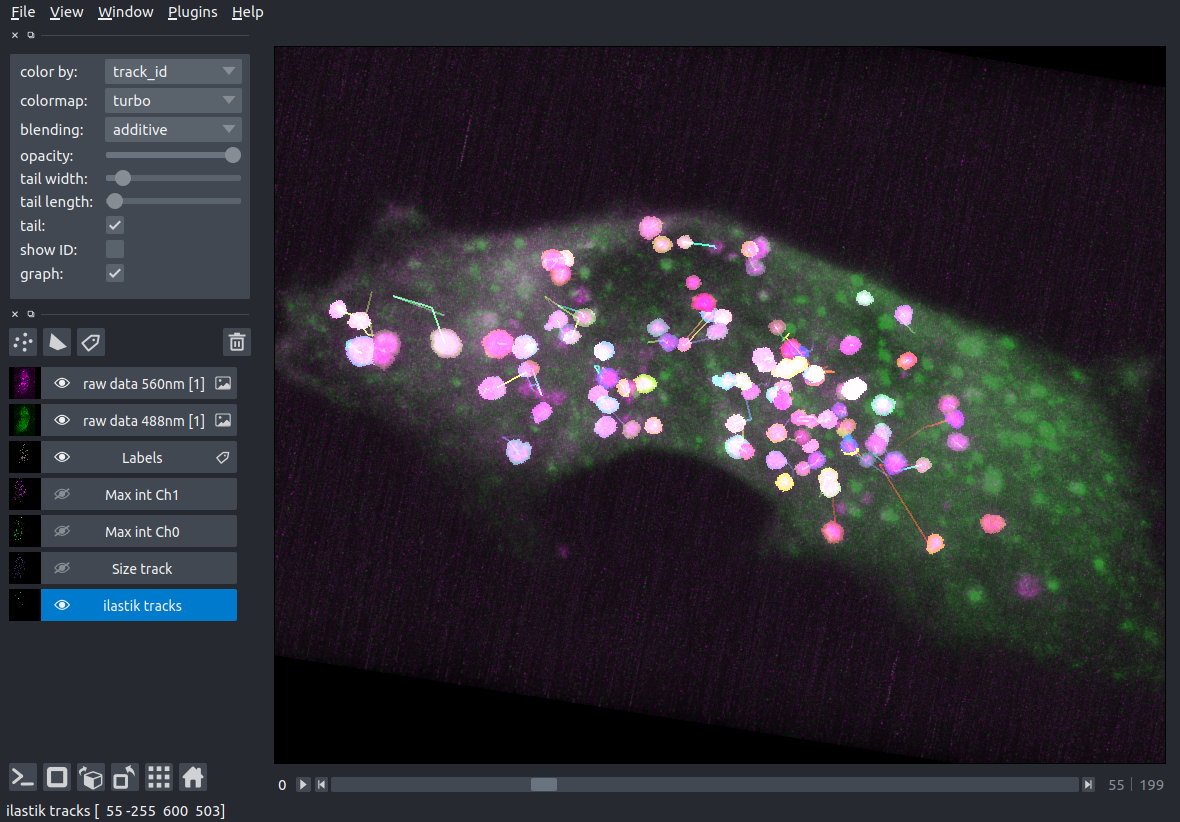

In [43]:
nbscreenshot(v)

With that many layers and the large volumes, switching between time points becomes quite laggy on my machine, despite lazy loading.
The volume rendering really helps for proof-reading the results, both in terms of the initial segmentation (in the above screenshot it is obvious that many of the green endosomes were missed) as well as for the tracking. 

Note that for proof reading tracking results I find it useful to reduce the tail length of the track to `1` and flick back and forth between adjacent time points.

Unfortunately, when one is unhappy with the results the ilastik tracking needs to be adjusted and run again. There is no way to manually correct or add tracks.


## TODO:

This could be improved by showing how to deal with lineages during split and/or merge events and demonstrate some of the other parameters.
